In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import umap

/home/renan/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-21 20:57:03.550206: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 20:57:03.564305: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 20:57:03.677226: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 20:57:03.762251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register facto

In [5]:
sumo = {}
sumo_files = os.listdir('data_experiment1_sumo')
for file in sumo_files:
    sumo_df = pd.read_csv(f'data_experiment1_sumo/{file}')
    sumo[file.split(".")[0]] = sumo_df
print(sumo.keys())

dict_keys(['veh1_aggressive', 'veh0_normal'])


In [6]:
carla = {}
carla_files = os.listdir('data_experiment1_carla')
for file in carla_files:
    carla_df = pd.read_csv(f'data_experiment1_carla/{file}')
    carla_df.rename(columns={'latitude': 'y_pos', 'longitude': 'x_pos'}, inplace=True)
    carla_df['acc_z'] -= 9.8
    carla[file.split('.')[0]] = carla_df[carla_df['timestamp'] > 0]
print(carla.keys())

dict_keys(['veh1_aggressive', 'veh0_normal'])


In [7]:
carla['veh0_normal'].head()

,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,compass,y_pos,x_pos
1,0.1,0.010968,0.000016,0.009995,-8.460580e-07,-2.402338e-07,1.123803e-09,79.023772,42.062875,2.010618
2,0.2,0.010968,0.000016,0.009995,3.713866e-08,7.675618e-08,7.055396e-11,79.023772,42.062875,2.010618
3,0.3,0.010968,0.000016,0.009995,6.803985e-08,-1.879241e-08,-1.051146e-10,79.023772,42.062875,2.010618
4,0.4,4.380508,0.432028,-0.233158,1.965015e-02,-7.281802e-02,6.133822e-02,79.195190,42.062875,2.010618
5,0.5,8.420786,0.332284,-0.036370,-2.015688e-03,3.760713e-04,7.922637e-02,79.561493,42.062875,2.010620


In [8]:
sumo['veh0_normal'].head()

,timestamp,x_pos,y_pos,speed,speed_x,speed_y,acc,acc_x,acc_y,angle,acc_diff,gyro_z
0,0.1,1883.910905,6865.150060,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,77.082803,0.000000,0.0
1,0.2,1883.912581,6865.150444,0.017197,0.003844,0.016762,0.171968,0.038442,0.167616,77.082803,1.719681,0.0
2,0.3,1883.917354,6865.151539,0.048966,0.010946,0.047727,0.317689,0.071017,0.309649,77.082803,0.317689,0.0
3,0.4,1883.927608,6865.153890,0.105199,0.023517,0.102537,0.562335,0.125706,0.548104,77.082803,2.446460,0.0
4,0.5,1883.946926,6865.158321,0.198204,0.044307,0.193188,0.930050,0.207906,0.906515,77.082803,3.677155,0.0


The time series may have different lengths because of the routing and simulation of each simulator.

In [9]:
for (sumo_k, sumo_v), (carla_k, carla_v) in zip(sumo.items(), carla.items()):
    print(f'Sumo {sumo_k} size: {len(sumo_v)}. Carla {sumo_k} size: {len(carla_v)}')


Sumo veh1_aggressive size: 2838. Carla veh1_aggressive size: 2213
Sumo veh0_normal size: 3148. Carla veh0_normal size: 2568


Note que gyro_z não é obtido diretamente pelo SUMO, aqui está sendo realizada uma aproximação a partir da variação nos ângulos

In [10]:
def plot_df(sumo_df=None, carla_df=None, idx="", uah_df_imu=None, uah_df_gnss=None, save_path=None):
    fig, axes = plt.subplots(4, 2, figsize=(20, 18))
    axes = axes.flatten()
    alpha = 0.6

    # Plot acceleration X
    if sumo_df is not None:
        axes[0].plot(sumo_df['timestamp'], sumo_df['acc_x'], label='Sumo Acc X', alpha=alpha)
    if carla_df is not None:
        axes[0].plot(carla_df['timestamp'], carla_df['acc_x'], label='Carla Acc X', alpha=alpha)
    if uah_df_imu is not None:
        axes[0].plot(uah_df_imu['timestamp'], uah_df_imu['acc_x'], label='UAH Acc X', color='red', alpha=0.7)
    axes[0].set_title("Acceleration X over Time")
    axes[0].set_ylabel("Acceleration (m/s²)")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    if sumo_df is not None:
        axes[1].plot(sumo_df['timestamp'], sumo_df['acc_y'], label='Sumo Acc Y', alpha=alpha)
    if carla_df is not None:
        axes[1].plot(carla_df['timestamp'], carla_df['acc_y'], label='Carla Acc Y', alpha=alpha)
    if uah_df_imu is not None:
        axes[1].plot(uah_df_imu['timestamp'], uah_df_imu['acc_y'], label='UAH Acc Y', color='red', alpha=0.7)
    axes[1].set_title("Acceleration Y over Time")
    axes[1].set_ylabel("Acceleration (m/s²)")
    axes[1].legend()
    axes[1].grid(True)

    # Plot gyroscope Z
    if sumo_df is not None:
        axes[2].plot(sumo_df['timestamp'], sumo_df['gyro_z'], label='Sumo Gyro Z', alpha=alpha)
    if carla_df is not None:
        axes[2].plot(carla_df['timestamp'], carla_df['gyro_z'], label='Carla Gyro Z', alpha=alpha)
    if uah_df_imu is not None and 'Yaw' in uah_df_imu.columns:
        axes[2].plot(uah_df_imu['timestamp'], uah_df_imu['Yaw'], label='UAH Yaw', color='red', alpha=0.7)
    axes[2].set_title("Gyroscope Z over Time")
    axes[2].set_ylabel("Angular Velocity (rad/s)")
    axes[2].legend()
    axes[2].grid(True)

    axes_count = 3
    # Plot angle
    if uah_df_gnss is None:
        if sumo_df is not None:
            axes[axes_count].plot(sumo_df['timestamp'], sumo_df['angle'], label='Sumo Angle', alpha=alpha)
        if carla_df is not None:
            axes[axes_count].plot(carla_df['timestamp'], carla_df['compass'], label='Carla Angle', alpha=alpha)
        if uah_df_imu is not None and 'Yaw' in uah_df_imu.columns:
            axes[axes_count].plot(uah_df_imu['timestamp'], uah_df_imu['Yaw'], label='UAH Yaw', color='red', alpha=0.7)
        axes[axes_count].set_title("Angle over Time")
        axes[axes_count].set_ylabel("Angle (rad)")
        axes[axes_count].legend()
        axes[axes_count].grid(True)
        axes_count += 1

    # Plot Sumo position
    if sumo_df is not None:
        scatter = axes[axes_count].scatter(sumo_df['x_pos'], sumo_df['y_pos'], c=sumo_df['timestamp'], cmap='viridis', s=10, label='Sumo')
        axes[axes_count].set_title("Sumo Position over Time")
        axes[axes_count].set_xlabel("X position")
        axes[axes_count].set_ylabel("Y position")
        axes[axes_count].grid(True)
        cbar = fig.colorbar(scatter, ax=axes[axes_count])
        cbar.set_label("Time (s)")
        axes_count += 1

    # Plot Carla position
    if carla_df is not None:
        scatter = axes[axes_count].scatter(carla_df['x_pos'], carla_df['y_pos'], c=carla_df['timestamp'], cmap='viridis', s=10, label='Carla')
        axes[axes_count].set_title("Carla Position over Time")
        axes[axes_count].set_xlabel("X position")
        axes[axes_count].set_ylabel("Y position")
        axes[axes_count].grid(True)
        cbar = fig.colorbar(scatter, ax=axes[axes_count])
        cbar.set_label("Time (s)")
        axes_count += 1

    # Plot UAH position if available
    if uah_df_gnss is not None and 'lat' in uah_df_gnss.columns and 'lon' in uah_df_gnss.columns and 'timestamp' in uah_df_gnss.columns:
        scatter = axes[axes_count].scatter(uah_df_gnss['lon'], uah_df_gnss['lat'], c=uah_df_gnss['timestamp'], cmap='viridis', s=10, label='UAH', alpha=0.7)
        axes[axes_count].set_title("UAH Position over Time")
        axes[axes_count].set_xlabel("Longitude")
        axes[axes_count].set_ylabel("Latitude")
        axes[axes_count].grid(True)
        cbar = fig.colorbar(scatter, ax=axes[axes_count])
        cbar.set_label("Time (s)")
        axes_count += 1

    # Remove unused axes if any
    if axes_count < 8:
        for i in range(axes_count, 8):
            fig.delaxes(axes[i])

    fig.tight_layout(rect=[0, 0.03, 1, 0.96])

    if uah_df_imu is not None:
        if carla_df is not None:
            if sumo_df is not None:
                fig.suptitle(f'Comparison of SUMO, CARLA, and UAH Data for {idx}', fontsize=18)
            else:
                fig.suptitle(f'Comparison of CARLA and UAH Data for {idx}', fontsize=18)
        else:
            if sumo_df is not None:
                fig.suptitle(f'Comparison of SUMO and UAH Data for {idx}', fontsize=18)
            else:
                fig.suptitle(f'UAH Data for {idx}', fontsize=18)
    else:
        if carla_df is not None:
            if sumo_df is not None:
                fig.suptitle(f'Comparison of SUMO and CARLA Data for {idx}', fontsize=18)
            else:
                fig.suptitle(f'CARLA Data for {idx}', fontsize=18)
        else:
            if sumo_df is not None:
                fig.suptitle(f'SUMO Data for {idx}', fontsize=18)
            else:
                fig.suptitle(f'No data available for {idx}', fontsize=18)
    
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()


In [11]:
def plot_histograms(sumo_df, carla_df, idx, uah_df_imu = None, bins=50, save_path=None):
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    axes = axes.flatten()

    # Plot acceleration X
    axes[0].hist(sumo_df['acc_x'], bins=bins, alpha=0.5, label='Sumo Acc X', density=True, color='blue')
    axes[0].hist(carla_df['acc_x'], bins=bins, alpha=0.5, label='Carla Acc X', density=True, color='orange')
    sumo_df['acc_x'].plot(kind='kde', ax=axes[0], label='Sumo Acc X KDE', color='blue')
    carla_df['acc_x'].plot(kind='kde', ax=axes[0], label='Carla Acc X KDE', color='orange')
    if uah_df_imu is not None and 'acc_x' in uah_df_imu.columns:
        axes[0].hist(uah_df_imu['acc_x'], bins=bins, alpha=0.5, label='UAH Acc X', density=True, color='green')
        uah_df_imu['acc_x'].plot(kind='kde', ax=axes[0], label='UAH Acc X KDE', color='green')
    axes[0].set_title("Acceleration X Histogram")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    axes[1].hist(sumo_df['acc_y'], bins=bins, alpha=0.5, label='Sumo Acc Y', density=True, color='blue')
    axes[1].hist(carla_df['acc_y'], bins=bins, alpha=0.5, label='Carla Acc Y', density=True, color='orange')
    sumo_df['acc_y'].plot(kind='kde', ax=axes[1], label='Sumo Acc Y KDE', color='blue')
    carla_df['acc_y'].plot(kind='kde', ax=axes[1], label='Carla Acc Y KDE', color='orange')
    if uah_df_imu is not None and 'acc_y' in uah_df_imu.columns:
        axes[1].hist(uah_df_imu['acc_y'], bins=bins, alpha=0.5, label='UAH Acc Y', density=True, color='green')
        uah_df_imu['acc_y'].plot(kind='kde', ax=axes[1], label='UAH Acc Y KDE', color='green')
    axes[1].set_title("Acceleration Y Histogram")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].grid(True)

    # Plot gyroscope Z
    axes[2].hist(sumo_df['gyro_z'], bins=bins, alpha=0.5, label='Sumo Gyro Z', density=True, color='blue')
    axes[2].hist(carla_df['gyro_z'], bins=bins, alpha=0.5, label='Carla Gyro Z', density=True, color='orange')
    sumo_df['gyro_z'].plot(kind='kde', ax=axes[2], label='Sumo Gyro Z KDE', color='blue')
    carla_df['gyro_z'].plot(kind='kde', ax=axes[2], label='Carla Gyro Z KDE', color='orange')
    if uah_df_imu is not None and 'Yaw' in uah_df_imu.columns:
        axes[2].hist(uah_df_imu['Yaw'], bins=bins, alpha=0.5, label='UAH Yaw', density=True, color='green')
        uah_df_imu['Yaw'].plot(kind='kde', ax=axes[2], label='UAH Yaw KDE', color='green')
    axes[2].set_title("Gyroscope Z Histogram")
    axes[2].set_ylabel("Density")
    axes[2].legend()
    axes[2].grid(True)

    # Plot angle
    axes[3].hist(sumo_df['angle'], bins=bins, alpha=0.5, label='Sumo Angle', density=True, color='blue')
    axes[3].hist(carla_df['compass'], bins=bins, alpha=0.5, label='Carla Angle', density=True, color='orange')
    sumo_df['angle'].plot(kind='kde', ax=axes[3], label='Sumo Angle KDE', color='blue')
    carla_df['compass'].plot(kind='kde', ax=axes[3], label='Carla Angle KDE', color='orange')
    axes[3].set_title("Angle Histogram")
    axes[3].set_ylabel("Density")
    axes[3].legend()
    axes[3].grid(True)

    # Set the main title
    fig.tight_layout(rect=[0, 0.03, 1, 0.96])  # Leave space at the top for suptitle
    fig.suptitle(f'Histogram Comparison of SUMO, CARLA, and UAH Data for {idx}', fontsize=18)
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()


## UAH-Driveset

In [12]:
def getData(driver, specifier, sensor):

    if sensor == 'acc':
        for i in os.listdir(f'UAH-DRIVESET-v1/{driver}'):
            if i.endswith(specifier):
                data = pd.read_csv(f'UAH-DRIVESET-v1/{driver}/{i}/RAW_ACCELEROMETERS.txt', sep=' ', header=None, names=[
                    'timestamp',
                    'system_active',
                    'acc_x',
                    'acc_y',
                    'acc_z',
                    'acc_x_KF',
                    'acc_y_KF',
                    'acc_z_KF',
                    'Roll',
                    'Pitch',
                    'Yaw'
                ], usecols=range(11))
                data = data.drop(['system_active'], axis=1)
                data['acc'] = np.sqrt(data['acc_x']**2 + data['acc_y']**2 + data['acc_z']**2)
                return data
            
    elif sensor == 'gps':
        for i in os.listdir(f'UAH-DRIVESET-v1/{driver}'):
            if i.endswith(specifier):
                data = pd.read_csv(f'UAH-DRIVESET-v1/{driver}/{i}/RAW_GPS.txt', sep=' ', header=None, names=[
                    'timestamp',
                    'speed',
                    'lat',
                    'lon',
                    'altitude',
                    'vert_accuracy',
                    'horiz_accuracy',
                    'course',
                    'difcourse',
                ], usecols=range(9))
                return data

In [13]:
def read_gps(drivers):
    normal = pd.DataFrame()
    aggressive = pd.DataFrame()
    drowsy = pd.DataFrame()
    for driver in drivers:
        # normal = pd.concat([normal, getData(driver, 'NORMAL1-SECONDARY', sensor='gps')], axis=0)
        normal = pd.concat([normal, getData(driver, 'NORMAL2-SECONDARY', sensor='gps')], axis=0)
        aggressive = pd.concat([aggressive, getData(driver, 'AGGRESSIVE-SECONDARY', sensor='gps')], axis=0)
        drowsy = pd.concat([drowsy, getData(driver, 'DROWSY-SECONDARY', sensor='gps')], axis=0)

    df_gps = {}
    df_gps['normal'] = normal
    df_gps['aggressive'] = aggressive
    df_gps['drowsy'] = drowsy

    return df_gps

In [14]:
def read_accelerometer(drivers):
    normal = pd.DataFrame()
    aggressive = pd.DataFrame()
    drowsy = pd.DataFrame()
    for driver in drivers:
        # normal = pd.concat([normal, getData(driver, 'NORMAL1-SECONDARY', sensor='acc')], axis=0)
        normal = pd.concat([normal, getData(driver, 'NORMAL2-SECONDARY', sensor='acc')], axis=0)
        aggressive = pd.concat([aggressive, getData(driver, 'AGGRESSIVE-SECONDARY', sensor='acc')], axis=0)
        drowsy = pd.concat([drowsy, getData(driver, 'DROWSY-SECONDARY', sensor='acc')], axis=0)

    df_accelerometer = {}
    df_accelerometer['normal'] = normal
    df_accelerometer['aggressive'] = aggressive
    df_accelerometer['drowsy'] = drowsy

    return df_accelerometer

Reading from only one driver and one run to be able to compare

In [15]:
drivers = ['D1']

In [16]:
df_acc = read_accelerometer(drivers)
df_gps = read_gps(drivers)

In [17]:
df_gps['normal']

,timestamp,speed,lat,lon,altitude,vert_accuracy,horiz_accuracy,course,difcourse
0,31.87,65.7,40.584465,-3.557142,601.2,6,5,94.6,0.703
1,32.90,69.0,40.584446,-3.556929,602.4,6,5,94.2,1.055
2,33.87,71.5,40.584435,-3.556698,603.4,6,5,93.2,1.406
3,34.89,74.7,40.584431,-3.556467,604.3,6,5,91.8,2.461
4,35.87,77.8,40.584435,-3.556209,605.9,6,5,90.7,2.461
...,...,...,...,...,...,...,...,...,...
622,653.95,113.7,40.519463,-3.410638,623.6,4,5,147.0,2.109
623,654.88,113.1,40.519226,-3.410432,623.7,4,5,144.8,2.109
624,655.89,112.3,40.518990,-3.410225,618.3,4,5,145.5,1.406
625,656.96,111.5,40.518757,-3.410029,619.0,4,5,146.2,1.406


In [18]:
df_acc['normal']

,timestamp,acc_x,acc_y,acc_z,acc_x_KF,acc_y_KF,acc_z_KF,Roll,Pitch,Yaw,acc
0,0.59,0.004,-0.039,-0.013,0.000,-0.006,-0.002,-1.686,0.131,0.156,0.041304
1,0.59,0.001,-0.035,-0.011,0.001,-0.021,-0.007,-1.686,0.131,0.157,0.036701
2,0.59,-0.020,-0.017,-0.019,-0.006,-0.024,-0.012,-1.686,0.131,0.158,0.032404
3,0.59,-0.029,-0.010,-0.022,-0.020,-0.015,-0.018,-1.686,0.131,0.158,0.037749
4,0.59,-0.029,-0.010,-0.022,-0.026,-0.012,-0.021,-1.686,0.131,0.158,0.037749
...,...,...,...,...,...,...,...,...,...,...,...
6518,657.58,-0.017,-0.017,0.009,-0.029,-0.022,-0.001,-1.505,-0.009,-0.804,0.025671
6519,657.68,0.017,-0.033,-0.003,-0.005,-0.025,-0.001,-1.503,-0.005,-0.802,0.037242
6520,657.79,0.014,-0.021,-0.003,0.009,-0.025,-0.001,-1.504,0.001,-0.800,0.025417
6521,657.88,0.010,-0.044,0.005,0.008,-0.033,0.001,-1.504,0.004,-0.799,0.045398


Simulated only up to lat, lon = 40.554174, -3.497402 because of simulation problems. Let's trim the dataset in this position

In [19]:
def trim_gnss(df_gnss, df_acc, lat, lon, lat_margin=0.0001, lon_margin=0.0001):

    # Define bounds
    lat_min = lat - lat_margin
    lat_max = lat + lat_margin
    lon_min = lon - lon_margin
    lon_max = lon + lon_margin

    # Find the first index within the interval
    condition = (
        (df_gnss['lat'] >= lat_min) & (df_gnss['lat'] <= lat_max) &
        (df_gnss['lon'] >= lon_min) & (df_gnss['lon'] <= lon_max)
    )

    # Get the first matching index
    matching_indices = df_gnss.index[condition]

    if not matching_indices.empty:
        timestamp = df_gnss['timestamp'].iloc[matching_indices[0]]
        closest_idx = matching_indices[0]
        print(f"Trimming GNSS data to timestamp: {timestamp}")
        gnss_trimmed = df_gnss.loc[:closest_idx].copy()
        print(f"Trimming accelerometer data to timestamp: {timestamp}")
        acc_trimmed = df_acc[df_acc['timestamp'] <= timestamp]
        return gnss_trimmed, acc_trimmed

    else:
        print("No point found within the specified interval.")
        gnss_trimmed = df_gnss.copy()  # or handle differently
    
    return gnss_trimmed, acc_trimmed

In [20]:
max_lat, max_lon = 40.554174, -3.497402
# Find all rows where lat and lon are within a small range of max_lat and max_lon
df_gps['normal'], df_acc['normal'] = trim_gnss(df_gps['normal'], df_acc['normal'], max_lat, max_lon, lat_margin=0.0005, lon_margin=0.0005)
df_gps['aggressive'], df_acc['aggressive'] = trim_gnss(df_gps['aggressive'], df_acc['aggressive'], max_lat, max_lon, lat_margin=0.0001, lon_margin=0.0001)

Trimming GNSS data to timestamp: 278.88
Trimming accelerometer data to timestamp: 278.88
Trimming GNSS data to timestamp: 324.2
Trimming accelerometer data to timestamp: 324.2


In [21]:
mean_normal = df_gps['normal']['speed'].mean()
max_normal = df_gps['normal']['speed'].max()
mean_aggressive = df_gps['aggressive']['speed'].mean()
max_aggressive = df_gps['aggressive']['speed'].max()

print(f"Normal:    Mean speed = {mean_normal:.2f} km/h, Max speed = {max_normal:.2f} km/h")
print(f"Aggressive: Mean speed = {mean_aggressive:.2f} km/h, Max speed = {max_aggressive:.2f} km/h")

# Convert to m/s (1 km/h = 0.27778 m/s)
mean_normal_ms = mean_normal * 0.27778
max_normal_ms = max_normal * 0.27778
mean_aggressive_ms = mean_aggressive * 0.27778
max_aggressive_ms = max_aggressive * 0.27778

print(f"Normal:    Mean speed = {mean_normal_ms:.2f} m/s, Max speed = {max_normal_ms:.2f} m/s")
print(f"Aggressive: Mean speed = {mean_aggressive_ms:.2f} m/s, Max speed = {max_aggressive_ms:.2f} m/s")


Normal:    Mean speed = 94.29 km/h, Max speed = 100.50 km/h
Aggressive: Mean speed = 114.23 km/h, Max speed = 128.10 km/h
Normal:    Mean speed = 26.19 m/s, Max speed = 27.92 m/s
Aggressive: Mean speed = 31.73 m/s, Max speed = 35.58 m/s


In [22]:
def plot_gps(df_gps, sumo_df=None, carla_df=None):
    fig, axes = plt.subplots(1, 3, figsize=(25, 5))

    # Plot UAH GPS
    axes[0].scatter(df_gps['lon'], df_gps['lat'], c=df_gps['timestamp'], cmap='viridis', s=10)
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[0].set_title("UAH Position")
    cbar0 = fig.colorbar(axes[0].collections[0], ax=axes[0])
    cbar0.set_label("Time (s)")
    axes[0].grid(True)

    # Plot SUMO
    if sumo_df is not None:
        axes[1].scatter(sumo_df['x_pos'], sumo_df['y_pos'], c=sumo_df['timestamp'], cmap='viridis', s=10)
        axes[1].set_xlabel("X position")
        axes[1].set_ylabel("Y position")
        axes[1].set_title("SUMO Position")
        cbar1 = fig.colorbar(axes[1].collections[0], ax=axes[1])
        cbar1.set_label("Time (s)")
        axes[1].grid(True)

    # Plot CARLA
    if carla_df is not None:
        axes[2].scatter(carla_df['x_pos'], carla_df['y_pos'], c=carla_df['timestamp'], cmap='viridis', s=10)
        axes[2].set_xlabel("X position")
        axes[2].set_ylabel("Y position")
        axes[2].set_title("CARLA Position")
        cbar2 = fig.colorbar(axes[2].collections[0], ax=axes[2])
        cbar2.set_label("Time (s)")
        axes[2].grid(True)

    plt.tight_layout()
    plt.show()

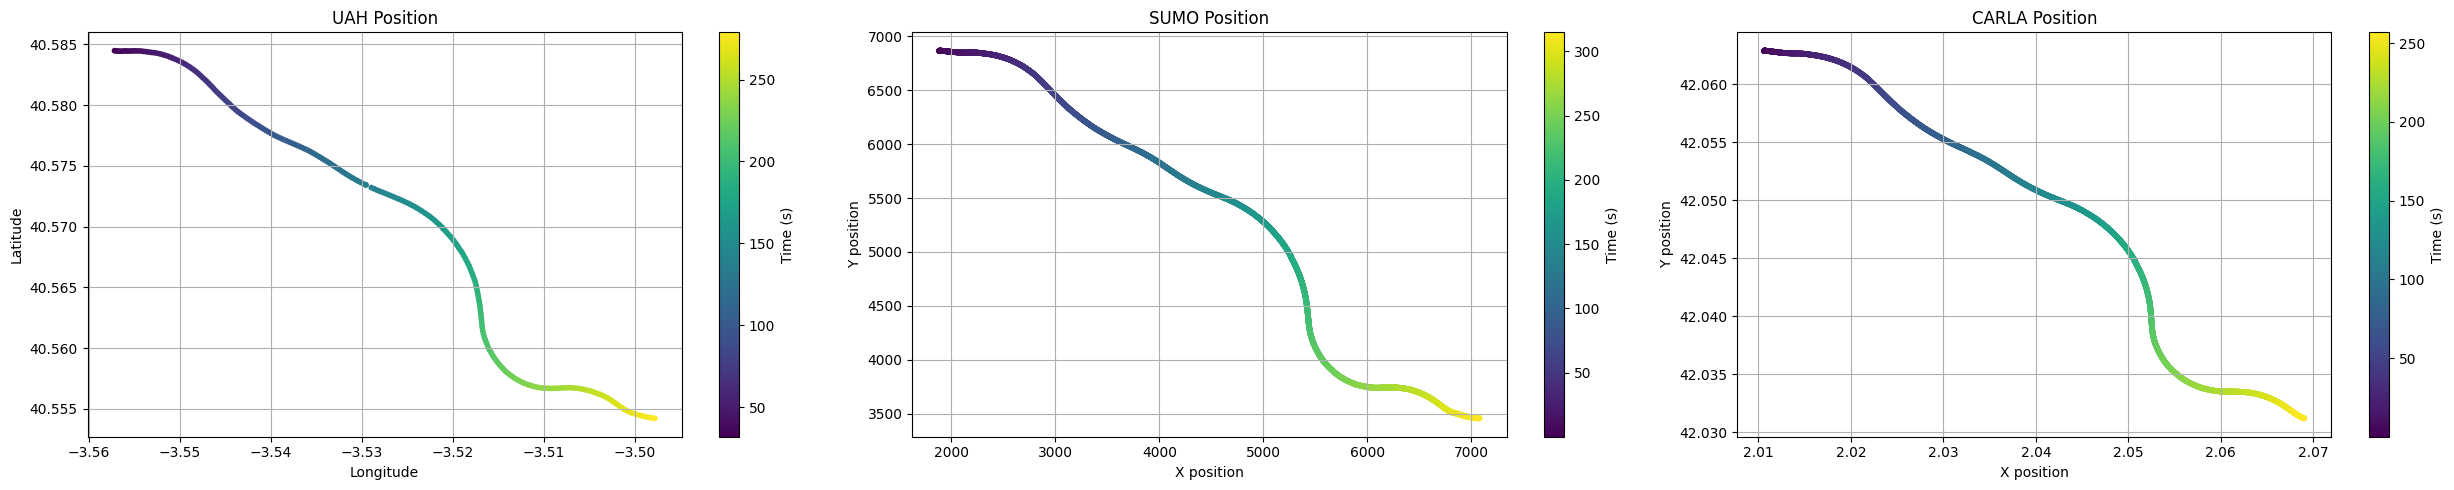

In [23]:
plot_gps(df_gps['normal'], sumo['veh0_normal'], carla['veh0_normal'])  

In [24]:
def plot_sumo_uah(sumo_df, uah_df_gnss, uah_df_imu, idx, save_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes = axes.flatten()
    alpha = 0.6

    # Plot acceleration X
    axes[0].plot(sumo_df['timestamp'], sumo_df['acc_x'], label='Sumo Acc X', alpha=alpha)
    axes[0].plot(uah_df_imu['timestamp'], uah_df_imu['acc_x'], label='UAH Acc X', color='red', alpha=0.7)
    axes[0].set_title("Acceleration X over Time")
    axes[0].set_ylabel("Acceleration (m/s²)")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    axes[1].plot(sumo_df['timestamp'], sumo_df['acc_y'], label='Sumo Acc Y', alpha=alpha)
    axes[1].plot(uah_df_imu['timestamp'], uah_df_imu['acc_y'], label='UAH Acc Y', color='red', alpha=0.7)
    axes[1].set_title("Acceleration Y over Time")
    axes[1].set_ylabel("Acceleration (m/s²)")
    axes[1].legend()
    axes[1].grid(True)

    # Plot gyroscope Z
    axes[2].plot(sumo_df['timestamp'], sumo_df['gyro_z'], label='Sumo Gyro Z', alpha=alpha)
    axes[2].plot(uah_df_imu['timestamp'], uah_df_imu['Yaw'], label='UAH Yaw', color='red', alpha=0.7)
    axes[2].set_title("Gyroscope Z over Time")
    axes[2].set_ylabel("Angular Velocity (rad/s)")
    axes[2].legend()
    axes[2].grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.94])
    
    fig.suptitle(f'Comparison of SUMO and UAH Data data for {idx.split('_')[-1]} vehicle', fontsize=16)

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes = axes.flatten()

    # Plot Sumo position
    scatter = axes[0].scatter(sumo_df['x_pos'], sumo_df['y_pos'], c=sumo_df['timestamp'], cmap='viridis', s=10, label='Sumo')
    axes[0].set_title("Sumo Position over Time")
    axes[0].set_xlabel("X position")
    axes[0].set_ylabel("Y position")
    axes[0].grid(True)
    cbar = fig.colorbar(scatter, ax=axes[0])
    cbar.set_label("Time (s)")

    # Plot UAH position if available
    scatter = axes[1].scatter(uah_df_gnss['lon'], uah_df_gnss['lat'], c=uah_df_gnss['timestamp'], cmap='viridis', s=10, label='UAH')
    axes[1].set_title("UAH Position over Time")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")
    axes[1].grid(True)
    cbar = fig.colorbar(scatter, ax=axes[1])
    cbar.set_label("Time (s)")

    if save_path:
        plt.savefig(f'{save_path}_position.png')
        plt.close(fig)
    else:
        plt.show()

In [25]:
def plot_carla_uah(carla_df, uah_df_imu, uah_df_gnss, veh, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()
    alpha = 0.6

    # Plot acceleration X
    axes[0].plot(carla_df['timestamp'], carla_df['acc_x'], label='Carla Acc X', alpha=alpha)
    axes[0].plot(uah_df_imu['timestamp'], uah_df_imu['acc_x'], label='UAH Acc X', color='red', alpha=0.7)
    axes[0].set_title("Acceleration X over Time")
    axes[0].set_ylabel("Acceleration (m/s²)")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    axes[1].plot(carla_df['timestamp'], carla_df['acc_y'], label='Carla Acc Y', alpha=alpha)
    axes[1].plot(uah_df_imu['timestamp'], uah_df_imu['acc_y'], label='UAH Acc Y', color='red', alpha=0.7)
    axes[1].set_title("Acceleration Y over Time")
    axes[1].set_ylabel("Acceleration (m/s²)")
    axes[1].legend()
    axes[1].grid(True)

    # Plot acceleration Z
    axes[2].plot(carla_df['timestamp'], carla_df['acc_z'], label='Carla Acc Z', alpha=alpha)
    axes[2].plot(uah_df_imu['timestamp'], uah_df_imu['acc_z'], label='UAH Acc Z', color='red', alpha=0.7)
    axes[2].set_title("Acceleration Z over Time")
    axes[2].set_ylabel("Acceleration (m/s²)")
    axes[2].legend()
    axes[2].grid(True)

    # Plot gyroscope X
    axes[3].plot(carla_df['timestamp'], carla_df['gyro_x'], label='Carla Gyro X', alpha=alpha)
    axes[3].plot(uah_df_imu['timestamp'], uah_df_imu['Roll'], label='UAH Roll', color='red', alpha=0.7)
    axes[3].set_title("Gyroscope X over Time")
    axes[3].set_ylabel("Angular Velocity (rad/s)")
    axes[3].legend()
    axes[3].grid(True)

    # Plot gyroscope Y
    axes[4].plot(carla_df['timestamp'], carla_df['gyro_y'], label='Carla Gyro Y', alpha=alpha)
    axes[4].plot(uah_df_imu['timestamp'], uah_df_imu['Pitch'], label='UAH Pitch', color='red', alpha=0.7)
    axes[4].set_title("Gyroscope Y over Time")
    axes[4].set_ylabel("Angular Velocity (rad/s)")
    axes[4].legend()
    axes[4].grid(True)

    # Plot gyroscope Z
    axes[5].plot(carla_df['timestamp'], carla_df['gyro_z'], label='Carla Gyro Z', alpha=alpha)
    axes[5].plot(uah_df_imu['timestamp'], uah_df_imu['Yaw'], label='UAH Yaw', color='red', alpha=0.7)
    axes[5].set_title("Gyroscope Z over Time")
    axes[5].set_ylabel("Angular Velocity (rad/s)")
    axes[5].legend()
    axes[5].grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.94])

    fig.suptitle(f'Comparison of CARLA and UAH Data for {veh.split('_')[-1]} vehicle', fontsize=16)

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes = axes.flatten()

    # Plot Carla position
    scatter = axes[0].scatter(carla_df['x_pos'], carla_df['y_pos'], c=carla_df['timestamp'], cmap='viridis', s=10, label='Carla')
    axes[0].set_title("Carla Position over Time")
    axes[0].set_xlabel("X position")
    axes[0].set_ylabel("Y position")
    axes[0].grid(True)
    cbar = fig.colorbar(scatter, ax=axes[0])
    cbar.set_label("Time (s)")

    # Plot UAH position if available
    scatter = axes[1].scatter(uah_df_gnss['lon'], uah_df_gnss['lat'], c=uah_df_gnss['timestamp'], cmap='viridis', s=10, label='UAH')
    axes[1].set_title("UAH Position over Time")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")
    axes[1].grid(True)
    cbar = fig.colorbar(scatter, ax=axes[1])
    cbar.set_label("Time (s)")

    if save_path:
        plt.savefig(f'{save_path}_position.png')
        plt.close(fig)
    else:
        plt.show()

In [26]:
def hist_sumo_uah(sumo_df, uah_df_imu, uah_df_gnss, veh, save_path=None):
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes = axes.flatten()

    # Plot acceleration X
    axes[0].hist(sumo_df['acc_x'], bins=50, alpha=0.5, label='Sumo Acc X', density=True, color='blue')
    axes[0].hist(uah_df_imu['acc_x'], bins=50, alpha=0.5, label='UAH Acc X', density=True, color='green')
    sumo_df['acc_x'].plot(kind='kde', ax=axes[0], label='Sumo Acc X KDE', color='blue')
    uah_df_imu['acc_x'].plot(kind='kde', ax=axes[0], label='UAH Acc X KDE', color='green')
    axes[0].set_title("Acceleration X Histogram")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    axes[1].hist(sumo_df['acc_y'], bins=50, alpha=0.5, label='Sumo Acc Y', density=True, color='blue')
    axes[1].hist(uah_df_imu['acc_y'], bins=50, alpha=0.5, label='UAH Acc Y', density=True, color='green')
    sumo_df['acc_y'].plot(kind='kde', ax=axes[1], label='Sumo Acc Y KDE', color='blue')
    uah_df_imu['acc_y'].plot(kind='kde', ax=axes[1], label='UAH Acc Y KDE', color='green')
    axes[1].set_title("Acceleration Y Histogram")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].grid(True)

    # Plot gyroscope Z
    axes[2].hist(sumo_df['gyro_z'], bins=50, alpha=0.5, label='Sumo Gyro Z', density=True, color='blue')
    axes[2].hist(uah_df_imu['Yaw'], bins=50, alpha=0.5, label='UAH Yaw', density=True, color='green')
    sumo_df['gyro_z'].plot(kind='kde', ax=axes[2], label='Sumo Gyro Z KDE', color='blue')
    uah_df_imu['Yaw'].plot(kind='kde', ax=axes[2], label='UAH Yaw KDE', color='green')
    axes[2].set_title("Gyroscope Z Histogram")
    axes[2].set_ylabel("Density")
    axes[2].legend()
    axes[2].grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.94])  # Leave space at the top for suptitle
    fig.suptitle(f'Histogram Comparison of SUMO and UAH Data for {veh.split("_")[-1]} vehicle', fontsize=16)
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [27]:
def hist_carla_uah(carla_df, uah_df_imu, uah_df_gnss, veh, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()
    alpha = 0.6

    # Acceleration X histogram
    axes[0].hist(carla_df['acc_x'], bins=50, alpha=0.5, label='Carla Acc X', density=True, color='blue')
    axes[0].hist(uah_df_imu['acc_x'], bins=50, alpha=0.5, label='UAH Acc X', density=True, color='green')
    carla_df['acc_x'].plot(kind='kde', ax=axes[0], label='Carla Acc X KDE', color='blue')
    uah_df_imu['acc_x'].plot(kind='kde', ax=axes[0], label='UAH Acc X KDE', color='green')
    axes[0].set_title("Acceleration X Histogram")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].grid(True)

    # Acceleration Y histogram
    axes[1].hist(carla_df['acc_y'], bins=50, alpha=0.5, label='Carla Acc Y', density=True, color='blue')
    axes[1].hist(uah_df_imu['acc_y'], bins=50, alpha=0.5, label='UAH Acc Y', density=True, color='green')
    carla_df['acc_y'].plot(kind='kde', ax=axes[1], label='Carla Acc Y KDE', color='blue')
    uah_df_imu['acc_y'].plot(kind='kde', ax=axes[1], label='UAH Acc Y KDE', color='green')
    axes[1].set_title("Acceleration Y Histogram")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].grid(True)

    # Acceleration Z histogram
    axes[2].hist(carla_df['acc_z'], bins=50, alpha=0.5, label='Carla Acc Z', density=True, color='blue')
    axes[2].hist(uah_df_imu['acc_z'], bins=50, alpha=0.5, label='UAH Acc Z', density=True, color='green')
    carla_df['acc_z'].plot(kind='kde', ax=axes[2], label='Carla Acc Z KDE', color='blue')
    uah_df_imu['acc_z'].plot(kind='kde', ax=axes[2], label='UAH Acc Z KDE', color='green')
    axes[2].set_title("Acceleration Z Histogram")
    axes[2].set_ylabel("Density")
    axes[2].legend()
    axes[2].grid(True)

    # Gyroscope X histogram
    axes[3].hist(carla_df['gyro_x'], bins=50, alpha=0.5, label='Carla Gyro X', density=True, color='blue')
    axes[3].hist(uah_df_imu['Roll'], bins=50, alpha=0.5, label='UAH Roll', density=True, color='green')
    carla_df['gyro_x'].plot(kind='kde', ax=axes[3], label='Carla Gyro X KDE', color='blue')
    uah_df_imu['Roll'].plot(kind='kde', ax=axes[3], label='UAH Roll KDE', color='green')
    axes[3].set_title("Gyroscope X Histogram")
    axes[3].set_ylabel("Density")
    axes[3].legend()
    axes[3].grid(True)

    # Gyroscope Y histogram
    axes[4].hist(carla_df['gyro_y'], bins=50, alpha=0.5, label='Carla Gyro Y', density=True, color='blue')
    axes[4].hist(uah_df_imu['Pitch'], bins=50, alpha=0.5, label='UAH Pitch', density=True, color='green')
    carla_df['gyro_y'].plot(kind='kde', ax=axes[4], label='Carla Gyro Y KDE', color='blue')
    uah_df_imu['Pitch'].plot(kind='kde', ax=axes[4], label='UAH Pitch KDE', color='green')
    axes[4].set_title("Gyroscope Y Histogram")
    axes[4].set_ylabel("Density")
    axes[4].legend()
    axes[4].grid(True)

    # Gyroscope Z histogram
    axes[5].hist(carla_df['gyro_z'], bins=50, alpha=0.5, label='Carla Gyro Z', density=True, color='blue')
    axes[5].hist(uah_df_imu['Yaw'], bins=50, alpha=0.5, label='UAH Yaw', density=True, color='green')
    carla_df['gyro_z'].plot(kind='kde', ax=axes[5], label='Carla Gyro Z KDE', color='blue')
    uah_df_imu['Yaw'].plot(kind='kde', ax=axes[5], label='UAH Yaw KDE', color='green')
    axes[5].set_title("Gyroscope Z Histogram")
    axes[5].set_ylabel("Density")
    axes[5].legend()
    axes[5].grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.94])

    fig.suptitle(f'Comparison of CARLA and UAH Data for {veh.split('_')[-1]} vehicle', fontsize=16)

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()


In [28]:
os.makedirs('plots_hist', exist_ok=True)
os.makedirs('plots_uah', exist_ok=True)
for id in carla.keys():
    if id.split('_')[1] == 'normal':
        plot_carla_uah(carla[id], uah_df_imu=df_acc['normal'], uah_df_gnss=df_gps['normal'], veh=id, save_path=f'plots_uah/carla_{id}.png')
        hist_carla_uah(carla[id], uah_df_imu=df_acc['normal'], uah_df_gnss=df_gps['normal'], veh=id, save_path=f'plots_hist/carla_{id}.png')
    else:
        plot_carla_uah(carla[id], uah_df_imu=df_acc['aggressive'], uah_df_gnss=df_gps['aggressive'], veh=id, save_path=f'plots_uah/carla_{id}.png')
        hist_carla_uah(carla[id], uah_df_imu=df_acc['aggressive'], uah_df_gnss=df_gps['aggressive'], veh=id, save_path=f'plots_hist/carla_{id}.png')

In [30]:
for id in sumo.keys():
    if id.split('_')[1] == 'normal':
        plot_sumo_uah(sumo[id], uah_df_gnss=df_gps['normal'], uah_df_imu=df_acc['normal'], idx=id, save_path=f'plots_uah/sumo_{id}.png')
        hist_sumo_uah(sumo[id], uah_df_imu=df_acc['normal'], uah_df_gnss=df_gps['normal'], veh=id, save_path=f'plots_hist/sumo_{id}.png')
    else:
        plot_sumo_uah(sumo[id], uah_df_gnss=df_gps['aggressive'], uah_df_imu=df_acc['aggressive'], idx=id, save_path=f'plots_uah/sumo_{id}.png')
        hist_sumo_uah(sumo[id], uah_df_imu=df_acc['aggressive'], uah_df_gnss=df_gps['aggressive'], veh=id, save_path=f'plots_hist/sumo_{id}.png')

# Comparison Metrics

In [31]:
import numpy as np
from scipy.stats import entropy, wasserstein_distance, ks_2samp
from scipy.spatial.distance import jensenshannon

In [32]:
def compare_distributions(carla_data, sumo_data, bins=100):
    # Define common bin edges
    min_val = min(carla_data.min(), sumo_data.min())
    max_val = max(carla_data.max(), sumo_data.max())
    hist_bins = np.linspace(min_val, max_val, bins + 1)

    # Histogram with density=True to approximate PDFs
    carla_hist, _ = np.histogram(carla_data, bins=hist_bins, density=True)
    sumo_hist, _ = np.histogram(sumo_data, bins=hist_bins, density=True)

    # Avoid zero entries to prevent divide-by-zero in KL
    carla_hist += 1e-10
    sumo_hist += 1e-10

    # Normalize (just in case)
    carla_hist /= carla_hist.sum()
    sumo_hist /= sumo_hist.sum()

    # KL Divergence (not symmetric)
    kl_div = entropy(carla_hist, sumo_hist)

    # Jensen-Shannon Distance (symmetric and bounded)
    js_dist = jensenshannon(carla_hist, sumo_hist)

    # Wasserstein Distance (Earth Mover’s Distance)
    wasser_dist = wasserstein_distance(carla_data, sumo_data)

    # Kolmogorov–Smirnov Test (returns D-statistic and p-value)
    ks_stat, ks_pval = ks_2samp(carla_data, sumo_data)

    # Define which metrics are "bigger is better" (↑) or "smaller is better" (↓)
    # For these metrics, smaller is better: KL, JS, Wasserstein, KS Statistic
    # For KS p-value, bigger is better
    return {
        "KL Divergence ↓": kl_div,
        "Jensen-Shannon Distance ↓": js_dist,
        "Wasserstein Distance ↓": wasser_dist,
        "KS Statistic ↓": ks_stat,
        "KS p-value ↑": ks_pval
    }

In [33]:
sensors = ['acc_x', 'acc_y', 'gyro_z']
metrics_carla_sumo = {}
for id in carla.keys():
    beh = id.split('_')[1]
    
    metrics_carla_sumo[beh] = {}
    for sensor in sensors:
        metrics_carla_sumo[beh][sensor] = compare_distributions(carla[id][sensor], sumo[id][sensor])

In [34]:
sensors = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
metrics_carla_uah = {}
for id in carla.keys():
    beh = id.split('_')[1]
    if beh == 'normal':
        uah = df_acc['normal'].copy()
    else:
        uah = df_acc['aggressive'].copy()
    uah.rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'}, inplace=True)

    metrics_carla_uah[beh] = {}
    for sensor in sensors:
        metrics_carla_uah[beh][sensor] = compare_distributions(carla[id][sensor], uah[sensor])

In [35]:
sensors = ['acc_x', 'acc_y', 'gyro_z']
metrics_sumo_uah = {}
for id in sumo.keys():
    beh = id.split('_')[1]
    if beh == 'normal':
        uah = df_acc['normal'].copy()
    else:
        uah = df_acc['aggressive'].copy()
    uah.rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'}, inplace=True)

    metrics_sumo_uah[beh] = {}
    for sensor in sensors:
        metrics_sumo_uah[beh][sensor] = compare_distributions(sumo[id][sensor], uah[sensor])

In [38]:
# Getting a second real driver to compare with
df_acc_2 = read_accelerometer(['D2'])
df_gps_2 = read_gps(['D2'])
max_lat, max_lon = 40.554174, -3.497402
# Find all rows where lat and lon are within a small range of max_lat and max_lon
df_gps_2['normal'], df_acc_2['normal'] = trim_gnss(df_gps_2['normal'], df_acc_2['normal'], max_lat, max_lon, lat_margin=0.0005, lon_margin=0.0005)
df_gps_2['aggressive'], df_acc_2['aggresive'] = trim_gnss(df_gps_2['aggressive'], df_acc_2['aggressive'], max_lat, max_lon, lat_margin=0.0001, lon_margin=0.0001)

sensors = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
metrics_uah_uah = {}
for id in ['normal', 'aggressive']:
    if id == 'normal':
        uah_1 = df_acc['normal'].copy()
        uah_2 = df_acc_2['normal'].copy()
    else:
        uah_1 = df_acc['aggressive'].copy()
        uah_2 = df_acc_2['aggressive'].copy()

    uah_1 = df_acc[id].rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'})
    uah_2 = df_acc_2[id].rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'})

    metrics_uah_uah[id] = {}
    for sensor in sensors:
        metrics_uah_uah[id][sensor] = compare_distributions(uah_1[sensor], uah_2[sensor])

Trimming GNSS data to timestamp: 268.88
Trimming accelerometer data to timestamp: 268.88
Trimming GNSS data to timestamp: 369.53
Trimming accelerometer data to timestamp: 369.53


In [39]:
# Convert metrics dict to DataFrame for tabular display
print("Metrics for CARLA vs SUMO (normal):")
metrics_carla_sumo_df = pd.DataFrame(metrics_carla_sumo['normal']).T
display(metrics_carla_sumo_df)

print("Metrics for CARLA vs SUMO (aggressive):")
metrics_carla_sumo_df = pd.DataFrame(metrics_carla_sumo['aggressive']).T
display(metrics_carla_sumo_df)

print("Metrics for CARLA vs UAH (normal):")
metrics_carla_uah_df = pd.DataFrame(metrics_carla_uah['normal']).T
display(metrics_carla_uah_df)

print("Metrics for CARLA vs UAH (aggressive):")
metrics_carla_uah_df = pd.DataFrame(metrics_carla_uah['aggressive']).T
display(metrics_carla_uah_df)

print("Metrics for SUMO vs UAH (normal):")
metrics_sumo_uah_df = pd.DataFrame(metrics_sumo_uah['normal']).T
display(metrics_sumo_uah_df)

print("Metrics for SUMO vs UAH (aggressive):")
metrics_sumo_uah_df = pd.DataFrame(metrics_sumo_uah['aggressive']).T
display(metrics_sumo_uah_df)

print("Metrics for UAH (driver 1) vs UAH (driver 2) (normal):")
metrics_uah_uah_df = pd.DataFrame(metrics_uah_uah['normal']).T
display(metrics_uah_uah_df)

print("Metrics for UAH (driver 1) vs UAH (driver 2) (aggressive):")
metrics_uah_uah_df = pd.DataFrame(metrics_uah_uah['aggressive']).T
display(metrics_uah_uah_df)


Metrics for CARLA vs SUMO (normal):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,7.811364,0.622904,0.338063,0.472743,2.061252e-286
acc_y,6.460739,0.573320,0.653842,0.390710,3.567001e-193
gyro_z,1.386166,0.492818,0.067205,0.450589,3.241157e-259


Metrics for CARLA vs SUMO (aggressive):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,3.433532,0.259024,0.440975,0.514537,9.206539e-301
acc_y,6.558822,0.527754,0.892766,0.374765,5.162950e-156
gyro_z,1.036599,0.347816,0.065741,0.439994,5.184196e-217


Metrics for CARLA vs UAH (normal):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,15.571357,0.682338,0.361616,0.521977,8.497929e-322
acc_y,15.356578,0.617295,0.744903,0.437976,3.828257e-230
acc_z,0.300486,0.246853,0.013529,0.195967,3.341037e-45
gyro_x,24.944084,0.832555,1.586250,1.000000,0.000000e+00
gyro_y,2.108271,0.690690,0.053299,0.594804,0.000000e+00
gyro_z,21.748334,0.824146,2.480884,0.951555,0.000000e+00


Metrics for CARLA vs UAH (aggressive):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,3.471626,0.270042,0.461832,0.593370,1.383384e-321
acc_y,14.411708,0.586777,1.011726,0.467877,6.073918e-260
acc_z,0.449342,0.235000,0.019320,0.355114,2.416382e-147
gyro_x,25.364524,0.832555,1.585023,1.000000,0.000000e+00
gyro_y,1.562936,0.596556,0.031594,0.514827,1.524257e-317
gyro_z,2.720638,0.672118,0.405909,0.430595,8.090463e-219


Metrics for SUMO vs UAH (normal):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,0.940171,0.257725,0.025862,0.220562,3.144211e-63
acc_y,1.108050,0.265533,0.094002,0.177088,8.344839e-41
gyro_z,24.437666,0.823835,2.482334,0.950602,0.000000e+00


Metrics for SUMO vs UAH (aggressive):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,0.539698,0.194247,0.021317,0.156356,1.260608e-32
acc_y,2.299580,0.361019,0.119010,0.232131,1.034229e-71
gyro_z,3.941020,0.733450,0.434537,0.480977,1.984462e-316


Metrics for UAH (driver 1) vs UAH (driver 2) (normal):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,0.229881,0.107509,0.003041,0.050638,1.799382e-03
acc_y,0.482014,0.184005,0.010403,0.103762,3.454565e-13
acc_z,0.480569,0.158354,0.005810,0.062454,4.706334e-05
gyro_x,0.960005,0.277766,0.013126,0.200567,2.840066e-48
gyro_y,2.234798,0.253395,0.022660,0.131526,6.114725e-21
gyro_z,22.637164,0.816546,2.466520,0.951555,0.000000e+00


Metrics for UAH (driver 1) vs UAH (driver 2) (aggressive):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,0.174396,0.118741,0.007491,0.057926,1.308301e-06
acc_y,0.313236,0.104363,0.002508,0.029006,5.567399e-02
acc_z,0.419507,0.339388,0.020672,0.211528,2.774777e-83
gyro_x,0.763004,0.441523,0.042562,0.460119,5.889262e-321
gyro_y,1.996584,0.338815,0.014018,0.202496,2.600940e-76
gyro_z,1.880462,0.542869,0.648082,0.390090,1.003138e-287


In [40]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import gaussian_kde, energy_distance
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import cdist, pdist
# Optional: fix random seed for reproducibility
np.random.seed(42)

In [41]:
def multivariate_energy_distance(X, Y):
    # pairwise distances between X and Y
    XY_dist = cdist(X, Y, metric='euclidean')
    # pairwise distances within X
    XX_dist = pdist(X, metric='euclidean')
    # pairwise distances within Y
    YY_dist = pdist(Y, metric='euclidean')

    return 2 * XY_dist.mean() - XX_dist.mean() - YY_dist.mean()

In [42]:
def compare_multivariate_distributions(data1, data2, bandwidth=0.2, n_eval_points=1000, seed=42):
    rng = np.random.default_rng(seed)

    # 1. Energy Distance
    energy_dist = multivariate_energy_distance(data1, data2)

    # 2. Jensen-Shannon Distance (approximate with KDE)
    def js_distance_kde(p, q):
        kde_p = gaussian_kde(p.T, bw_method=bandwidth)
        kde_q = gaussian_kde(q.T, bw_method=bandwidth)

        points = np.vstack([p, q])
        eval_pts = points[rng.choice(len(points), n_eval_points, replace=False)]

        p_eval = kde_p(eval_pts.T)
        q_eval = kde_q(eval_pts.T)

        # Normalize densities to sum to 1
        p_eval /= p_eval.sum()
        q_eval /= q_eval.sum()

        return jensenshannon(p_eval, q_eval)

    js_dist = js_distance_kde(data1, data2)

    # 3. Maximum Mean Discrepancy (MMD)
    def compute_mmd(X, Y, gamma=1.0):
        XX = rbf_kernel(X, X, gamma=gamma)
        YY = rbf_kernel(Y, Y, gamma=gamma)
        XY = rbf_kernel(X, Y, gamma=gamma)
        return XX.mean() + YY.mean() - 2 * XY.mean()

    mmd = compute_mmd(data1, data2, gamma=1.0)

    return {
        'energy_distance': energy_dist,
        'js_distance': js_dist,
        'mmd': mmd
    }

Now tring multivariate approaches to give SUMO and CARLA another chance

In [43]:
mult_carla_uah = {}
for id in carla.keys():
    beh = id.split('_')[1]
    if beh == 'normal':
        uah = df_acc['normal'].copy()
    else:
        uah = df_acc['aggressive'].copy()
    
    uah.rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'}, inplace=True)

    # Assuming carla_df and uah_df are your dataframes
    carla_acc =(carla[id][['acc_x', 'acc_y', 'acc_z']]).to_numpy(dtype=np.float64)
    uah_acc =(uah[['acc_x', 'acc_y', 'acc_z']]).to_numpy(dtype=np.float64)
    carla_gyro =(carla[id][['gyro_x', 'gyro_y', 'gyro_z']]).to_numpy(dtype=np.float64)
    uah_gyro =(uah[['gyro_x', 'gyro_y', 'gyro_z']]).to_numpy(dtype=np.float64)

    acc_results = compare_multivariate_distributions(carla_acc, uah_acc)
    gyro_results = compare_multivariate_distributions(carla_gyro, uah_gyro)

    mult_carla_uah[beh] = {
        'acc': acc_results,
        'gyro': gyro_results
    }

In [44]:
mult_sumo_uah = {}
for id in sumo.keys():
    beh = id.split('_')[1]
    if beh == 'normal':
        uah = df_acc['normal'].copy()
    else:
        uah = df_acc['aggressive'].copy()

    # Assuming carla_df and uah_df are your dataframes
    sumo_acc = np.array(sumo[id][['acc_x', 'acc_y']])
    uah_acc = np.array(uah[['acc_x', 'acc_y']])

    acc_results = compare_multivariate_distributions(sumo_acc, uah_acc)

    mult_sumo_uah[beh] = {
        'acc': acc_results,
    }

In [45]:
mult_carla_sumo = {}
for id in sumo.keys():
    beh = id.split('_')[1]
    # Assuming carla_df and uah_df are your dataframes
    sumo_acc = np.array(sumo[id][['acc_x', 'acc_y']])
    carla_acc = np.array(carla[id][['acc_x', 'acc_y']])

    acc_results = compare_multivariate_distributions(sumo_acc, carla_acc)

    mult_carla_sumo[beh] = {
        'acc': acc_results,
    }


In [46]:
mult_uah_uah = {}
for id in ['normal', 'aggressive']:
    if id == 'normal':
        uah_1 = df_acc['normal'].copy()
        uah_2 = df_acc_2['normal'].copy()
    else:
        uah_1 = df_acc['aggressive'].copy()
        uah_2 = df_acc_2['aggressive'].copy()

    uah_1.rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'}, inplace=True)
    uah_2.rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'}, inplace=True)

    # Assuming carla_df and uah_df are your dataframes
    uah_1_acc = np.array(uah_1[['acc_x', 'acc_y', 'acc_z']])
    uah_2_acc = np.array(uah_2[['acc_x', 'acc_y', 'acc_z']])

    uah_1_gyro = np.array(uah_1[['gyro_x', 'gyro_y', 'gyro_z']])
    uah_2_gyro = np.array(uah_2[['gyro_x', 'gyro_y', 'gyro_z']])

    acc_results = compare_multivariate_distributions(uah_1_acc, uah_2_acc)
    gyro_results = compare_multivariate_distributions(uah_1_gyro, uah_2_gyro)

    mult_uah_uah[id] = {
        'acc': acc_results,
        'gyro': gyro_results
    }

In [47]:
# Convert metrics dict to DataFrame for tabular display
print("Metrics for CARLA vs SUMO (normal):")
mult_carla_sumo_df = pd.DataFrame(mult_carla_sumo['normal']).T
display(mult_carla_sumo_df)

print("Metrics for CARLA vs SUMO (aggressive):")
mult_carla_sumo_df = pd.DataFrame(mult_carla_sumo['aggressive']).T
display(mult_carla_sumo_df)

print("Metrics for CARLA vs UAH (normal):")
mult_carla_uah_df = pd.DataFrame(mult_carla_uah['normal']).T
display(mult_carla_uah_df)

print("Metrics for CARLA vs UAH (aggressive):")
mult_carla_uah_df = pd.DataFrame(mult_carla_uah['aggressive']).T
display(mult_carla_uah_df)

print("Metrics for SUMO vs UAH (normal):")
mult_sumo_uah_df = pd.DataFrame(mult_sumo_uah['normal']).T
display(mult_sumo_uah_df)

print("Metrics for SUMO vs UAH (aggressive):")
mult_sumo_uah_df = pd.DataFrame(mult_sumo_uah['aggressive']).T
display(mult_sumo_uah_df)

print("Metrics for UAH (driver 1) vs UAH (driver 2) (normal):")
mult_uah_uah_df = pd.DataFrame(mult_uah_uah['normal']).T
display(mult_uah_uah_df)

print("Metrics for UAH (driver 1) vs UAH (driver 2) (aggressive):")
mult_uah_uah_df = pd.DataFrame(mult_uah_uah['aggressive']).T
display(mult_uah_uah_df)

Metrics for CARLA vs SUMO (normal):


,energy_distance,js_distance,mmd
acc,0.371693,0.409557,0.261309


Metrics for CARLA vs SUMO (aggressive):


,energy_distance,js_distance,mmd
acc,0.458496,0.376912,0.324439


Metrics for CARLA vs UAH (normal):


,energy_distance,js_distance,mmd
acc,0.448776,0.561482,0.30111
gyro,5.166679,0.832555,1.76469


Metrics for CARLA vs UAH (aggressive):


,energy_distance,js_distance,mmd
acc,0.569410,0.433622,0.386315
gyro,2.643025,0.832555,1.501151


Metrics for SUMO vs UAH (normal):


,energy_distance,js_distance,mmd
acc,0.014727,0.271694,0.0021


Metrics for SUMO vs UAH (aggressive):


,energy_distance,js_distance,mmd
acc,0.019378,0.287168,0.003685


Metrics for UAH (driver 1) vs UAH (driver 2) (normal):


,energy_distance,js_distance,mmd
acc,0.000979,0.132356,0.000083
gyro,4.063868,0.832554,1.615752


Metrics for UAH (driver 1) vs UAH (driver 2) (aggressive):


,energy_distance,js_distance,mmd
acc,0.001805,0.275585,0.000011
gyro,0.376405,0.489128,0.184855


# Verificar tSNE do dado normal e da FFT

tSNE antes e depois da FFT

In [48]:
def plot_umap_uah_compare(data1, uah, features, id, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    for i, fft in enumerate([False, True]):
        data1_features = data1[id][features].values
        uah_key = id.split('_')[-1]
        uah[uah_key] = uah[uah_key].rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'})
        uah_features = uah[uah_key][features].values

        if fft:
            data1_features = np.abs(np.fft.fft(data1_features, axis=0))
            uah_features = np.abs(np.fft.fft(uah_features, axis=0))
            data1_features = data1_features[:data1_features.shape[0] // 2]
            uah_features = uah_features[:uah_features.shape[0] // 2]

        data1_labels = np.array(['synthetic'] * data1_features.shape[0])
        uah_labels = np.array(['real'] * uah_features.shape[0])
        all_features = np.vstack([data1_features, uah_features])
        all_labels = np.concatenate([data1_labels, uah_labels])

        reducer = umap.UMAP(random_state=42)
        embedding = reducer.fit_transform(all_features)

        for label, color in zip(['synthetic', 'real'], ['blue', 'orange']):
            idxs = all_labels == label
            axes[i].scatter(embedding[idxs, 0], embedding[idxs, 1], s=5, label=label, alpha=0.7, c=color)
        title = f"UMAP for {uah_key} driver {'(FFT)' if fft else '(Raw)'}"
        axes[i].set_title(title)
        axes[i].set_xlabel('UMAP 1')
        axes[i].set_ylabel('UMAP 2')
        axes[i].legend()
        axes[i].grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)

    plt.show()


In [49]:
os.makedirs('plots_umap', exist_ok=True)
plot_umap_uah_compare(carla, df_acc, ['acc_x', 'acc_y'], 'veh0_normal', save_path='plots_umap/carla_veh0_normal.png')
plot_umap_uah_compare(carla, df_acc, ['acc_x', 'acc_y'], 'veh1_aggressive', save_path='plots_umap/carla_veh1_aggressive.png')

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/

In [50]:
plot_umap_uah_compare(carla, df_acc, ['acc_x', 'acc_y', 'gyro_z'], 'veh0_normal', save_path='plots_umap/carla_veh0_normal_all.png')
plot_umap_uah_compare(carla, df_acc, ['acc_x', 'acc_y', 'gyro_z'], 'veh1_aggressive', save_path='plots_umap/carla_veh1_normal_all.png')

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/

In [51]:
plot_umap_uah_compare(sumo, df_acc, ['acc_x', 'acc_y'], 'veh0_normal', save_path='plots_umap/sumo_veh0_normal.png')
plot_umap_uah_compare(carla, df_acc, ['acc_x', 'acc_y'], 'veh1_aggressive', save_path='plots_umap/sumo_veh1_aggressive.png')

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/